# 4.5 权重衰减

In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [8]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.140127182006836


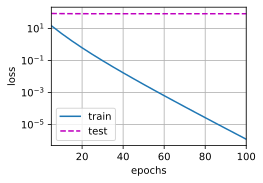

In [6]:
train(lambd=0)

w的L2范数是： 0.35804885625839233


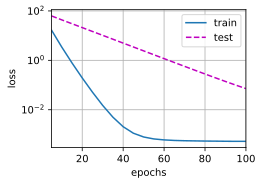

In [7]:
train(lambd=3)

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.52275276184082


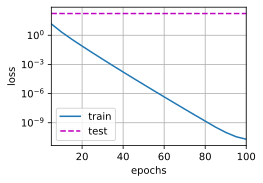

In [9]:
train_concise(0)

w的L2范数： 0.4823673963546753


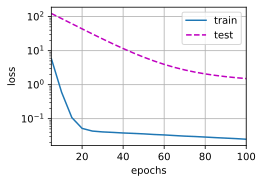

In [10]:
train_concise(3)

## 练习题

练习题 1：在本节的估计问题中使用 $\lambda$ 的值进行实验。绘制训练和测试精度关于 $\lambda$ 的函数。观察到了什么

w的L2范数： 0.005699815694242716


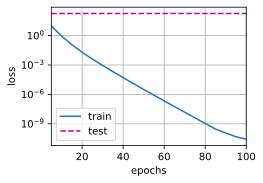

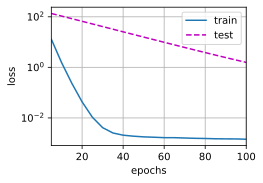

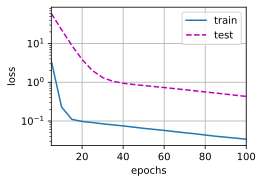

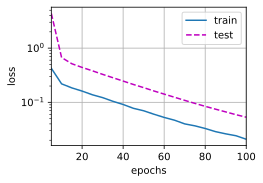

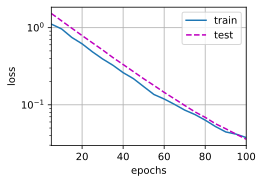

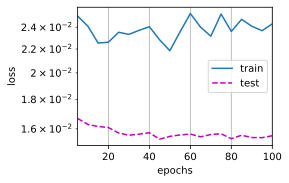

In [10]:
for i in (0, 2, 8, 32, 128, 256):
    train_concise(i)

$\lambda$ 的值较小时，正则化项的影响也会偏小，这时候模型可能会过拟合；$\lambda$ 的值过大时，因为正则化项，模型可能会欠拟合。

练习题 2：使用验证集来找到最佳值 $\lambda$。它真的是最优值吗？这有关系吗

不一定。使用验证集可以评估不同超参数下模型的性能，但并不能反映整个数据集上的真实性能。

练习题 3：如果我们使用 $\sum_i |w_i |$ 作为我们的惩罚（$L_1$ 正则化），那么更新方程会是什么样子

$$
L(\boldsymbol{w},b)= loss +\lambda\sum^n_{i=1}|w_i|
$$

练习题 4：我们知道 $|| w ||^2 = w^T w$。能找到类似的矩阵方程吗（见 2.3.10 节中的 Frobenius 范数）

$$
||\boldsymbol{X}||_F=\sqrt{\sum^m_{i=1}\sum^n_{j=1}x^2_{ij}}
$$

Frobenius 范数的平方：

$$
||\boldsymbol{X}||_F^2=\boldsymbol{X}^T\boldsymbol{X}
$$

练习题 5：回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，还能想出其他什么方法来处理过拟合

Dropout：在训练过程中，随机选择一部分神经元将其输出置为零，这样可以减少神经元之间的共适应性，一定程度上减少过拟合。

练习题 6：在贝叶斯统计中，我们使用先验和似然的乘积，通过公式 $P(w \mid x) \propto P(x \mid w) P(w)$ 得到后验。如何得到带正则化的 $P(w)$